
#  Bike Sharing Predictions in Washington D.C.

### Leandro Handal Baracatt 
#### MSc Management | MSc Business Analytics & Big Data	
#### <lhandalb@gmail.com>
  

### Context

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system in Washington, DC with the corresponding weather and seasonal information.

### Content

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: Record index
- dteday: Date
- season: Season (1:springer, 2:summer, 3:fall, 4:winter)
- yr: Year (0: 2011, 1:2012)
- mnth: Month (1 to 12)
- hr: Hour (0 to 23)
- holiday: weather day is holiday or not (extracted from Holiday Schedule)
- weekday: Day of the week
- workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit: (extracted from Freemeteo)
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 - (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, - t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered


### Acknowledgements

Hadi Fanaee-T Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto INESC Porto, Campus da FEUP Rua Dr. Roberto Frias, 378 4200 - 465 Porto, Portugal

Original Source: http://capitalbikeshare.com/system-data

Weather Information: http://www.freemeteo.com

Holiday Schedule: http://dchr.dc.gov/page/holiday-schedule

---

# Table Of Contents:

* [1. Importing Packages and Libraries](#1)

* [2. Reading Datasets and Creating DataFrames](#2)

* [3. Exploratory Data Analysis](#3)
    * [3.1 Variable Names and Encoding](#3.1)
    * [3.2 Frequencies](#3.2)
    * [3.3 Boxplot (Outliers)](#3.3)
    * [3.4 Relationship Between Variables](#3.4)

* [4. Feature Engineering](#4)
    * [4.1 Variable Creation](#4.1)
        * [ 4.1.1 Average Activity](#4.1.1)
        * [ 4.1.2 Commute Schedule](#4.1.2)
        * [ 4.1.3 Computed Apparent Temperature](#4.1.3)

* [5. Preprocessing](#5)
    * [5.1 Scaling and Normalizing](#5.1)
    * [5.2 Handling Outliers](#5.2)
        * [ 5.2.1 Clipping Outiers](#5.2.1)
        * [ 5.2.2 Other Outliers](#5.2.2)
    * [5.3 Dropping Variables](#5.3)
    * [5.4 One Hot Encoder](#5.4)
    * [5.5 Skewness](#5.5)
    * [5.6 Train/Test Split](#5.6)

* [6. Modeling](#6)
    * [6.1 Time Series Analysis](#6.1)
        * [6.1.1 Visualizing Data](#6.1.1)
        * [6.1.2 Forecasting With SARIMA Model](#6.1.2)
        * [6.1.3 Fitting the SARIMA Model](#6.1.3)
        * [6.1.4 Validating Forecasts](#6.1.4)
        * [6.1.5 Producing and Visualizing Forecasts](#6.1.5)
    * [6.2 Linear Models](#6.2)
        * [6.2.1 Linear Regression](#6.2.1)
        * [6.2.2 Lasso Regression](#6.2.2)
        * [6.2.3 Ridge Regression](#6.2.3)
        * [6.2.4 Elastic Net](#6.2.4)
        * [6.2.5 Linear SVM](#6.2.5)
    * [6.3 Non-Linear Models](#6.3)
        * [6.3.1 Non-Linear SVM](#6.3.1)
        * [6.3.2 Random Forest Regressor](#6.3.2)
        * [6.3.3 Gradient Boosting Regressor](#6.3.3)
        * [6.3.4 XGBoost Regressor](#6.3.4)
    * [6.4 Combining Models](#6.4)
        * [6.4.1 Weighted Average](#6.4.1)
        * [6.4.2 Stacking](#6.4.2)

* [7. Conclusions](#7)

# Importing Packages and Libraries <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score
from scikitplot.metrics import plot_calibration_curve
from scikitplot.plotters import plot_learning_curve
from scikitplot.estimators import plot_feature_importances
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from vecstack import stacking
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import dill
import itertools
from pylab import rcParams
import statsmodels.api as sm
import sys

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")

# Reading the Data<a class="anchor" id="2"></a>

In [2]:
day_url = "https://raw.githubusercontent.com/lhandal/bike_sharing/master/day.csv"
hour_url = "https://raw.githubusercontent.com/lhandal/bike_sharing/master/hour.csv"

day = pd.read_csv(day_url, parse_dates=["dteday"], index_col=0)
hour = pd.read_csv(hour_url, parse_dates=["dteday"], index_col=0)

In [3]:
day.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
hour.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
hour.dtypes

dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

   There are 0 null values in the Hour dataset.           There are 0 null values in the Day dataset.


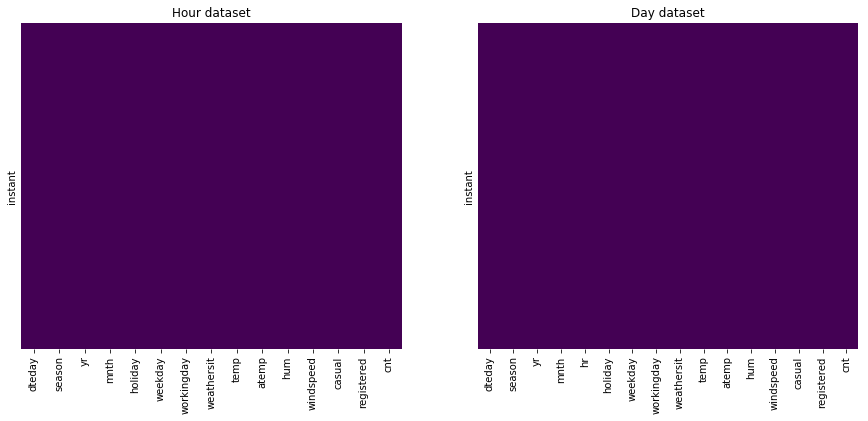

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(
    day.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax1
).set_title("Hour dataset")
sns.heatmap(
    hour.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax2
).set_title("Day dataset")

print(
    "   There are {} null values in the Hour dataset.           There are {} null values in the Day dataset.".format(
        hour.isnull().sum().sum(), day.isnull().sum().sum()
    )
)

# Exploratory Data Analysis<a class="anchor" id="3"></a>

## Variable Names and Encoding<a class="anchor" id="3.1"></a>

Before starting the EDA, we decided to make some adjustments to the column names and categorical values, in order to make them easier to read and understand.

In [7]:
day.rename(
    columns={
        "dteday": "datetime",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_condition",
        "hum": "humidity",
        "mnth": "month",
        "cnt": "total_count",
        "hr": "hour",
        "yr": "year",
    },
    inplace=True,
)


hour.rename(
    columns={
        "dteday": "datetime",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_condition",
        "hum": "humidity",
        "mnth": "month",
        "cnt": "total_count",
        "hr": "hour",
        "yr": "year",
    },
    inplace=True,
)

In [8]:
day = day.replace(
    {
        "season": {1: "spring", 2: "summer", 3: "fall", 4: "winter"},
        "year": {0: "2011", 1: "2012"},
        "month": {
            1: "january",
            2: "february",
            3: "march",
            4: "april",
            5: "may",
            6: "june",
            7: "july",
            8: "august",
            9: "september",
            10: "october",
            11: "november",
            12: "december",
        },
        "weekday": {
            0: "sunday",
            1: "monday",
            2: "tuesday",
            3: "wednesday",
            4: "thursday",
            5: "friday",
            6: "saturday",
        },
        "weather_condition": {
            1: "clear",
            2: "cloudy",
            3: "light_snow_rain",
            4: "heavy_snow_rain",
        },
    }
)

hour = hour.replace(
    {
        "season": {1: "spring", 2: "summer", 3: "fall", 4: "winter"},
        "year": {0: "2011", 1: "2012"},
        "month": {
            1: "january",
            2: "february",
            3: "march",
            4: "april",
            5: "may",
            6: "june",
            7: "july",
            8: "august",
            9: "september",
            10: "october",
            11: "november",
            12: "december",
        },
        "weekday": {
            0: "sunday",
            1: "monday",
            2: "tuesday",
            3: "wednesday",
            4: "thursday",
            5: "friday",
            6: "saturday",
        },
        "weather_condition": {
            1: "clear",
            2: "cloudy",
            3: "light_snow_rain",
            4: "heavy_snow_rain",
        },
    }
)

In [9]:
hour.head()

,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
instant,,,,,,,,,,,,,,,,
1,2011-01-01,spring,2011,january,0,0,saturday,0,clear,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,spring,2011,january,1,0,saturday,0,clear,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,spring,2011,january,2,0,saturday,0,clear,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,spring,2011,january,3,0,saturday,0,clear,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,spring,2011,january,4,0,saturday,0,clear,0.24,0.2879,0.75,0.0,0,1,1


Please take some time to appreciate how we color-coded all variables to match among plots and used appropriate colors to easily identify them! 😉

## Frequencies<a class="anchor" id="3.2"></a>

The following bar graph shows the count of bikes rented per season for the years 2011 and 2012. By doing so, we get a clear overview of how the target variable distributed over time.

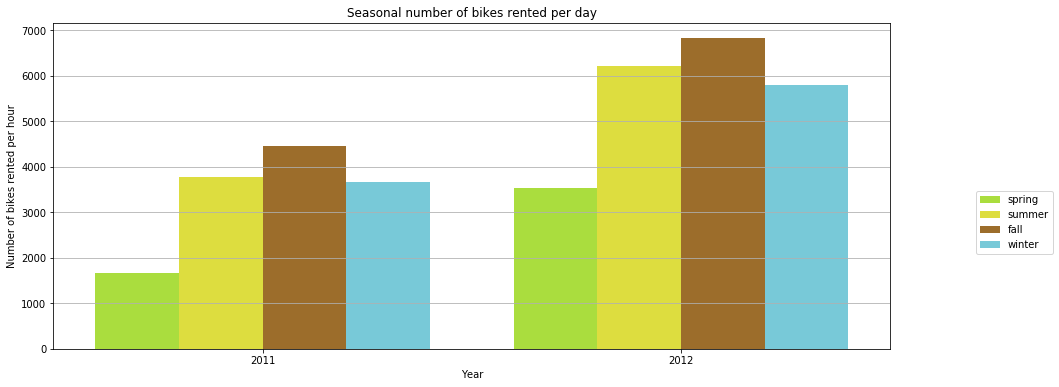

In [10]:
plt.figure(figsize=(15, 6))
sns.barplot(
    "year",
    "total_count",
    hue="season",
    data=day,
    palette=["#b4f724", "#f7f725", "#af7018", "#68d4e8"],
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Number of bikes rented per hour")
plt.title("Seasonal number of bikes rented per day")
plt.xticks(ticks=(0, 1), labels=("2011", "2012"))
plt.grid(which="major", axis="y")

* There was a substantial increase in bike renting from year 2011 to year 2012.
* However, the trend for number of bikes rented based on seasons is the same each year.
* Bikes are least rented in Spring and the most during Fall.
* After Spring, there is a sudden increase in bike renting during summer.

After looking at the differences per season, we zoom into each season and month to see what the drivers are for bike renting in terms of weather and type of day in the week. This done by multiple bar grahps.

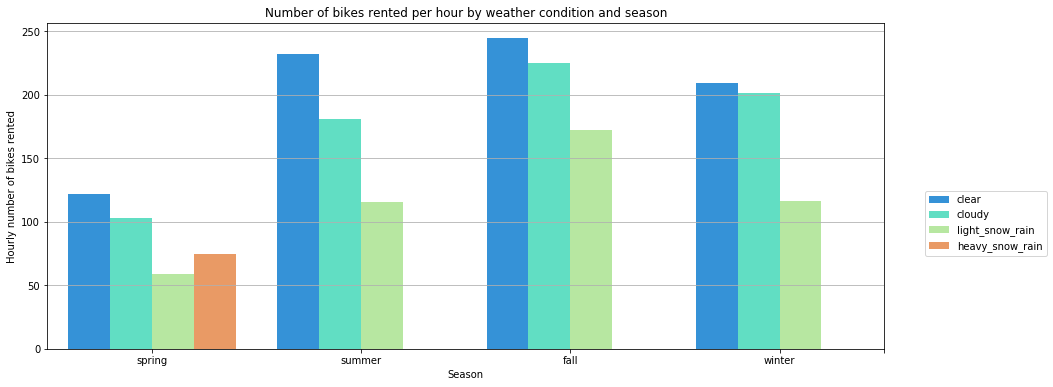

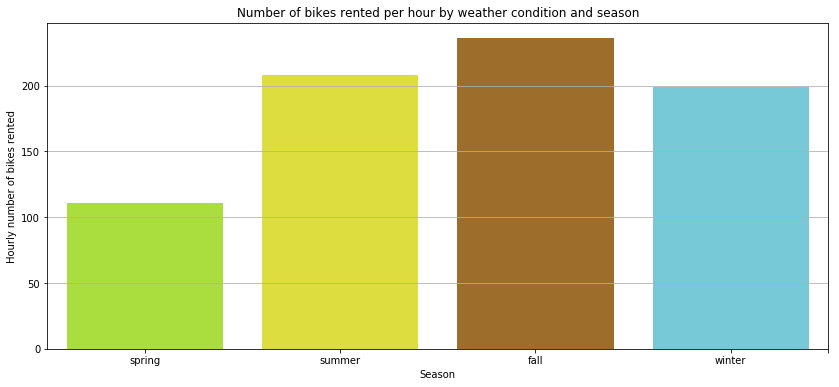

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(
    "season",
    "total_count",
    hue="weather_condition",
    data=hour,
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Season")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by weather condition and season")
plt.xticks(ticks=(0, 1, 2, 3, 3.5))
plt.grid(which="major", axis="y")

plt.figure(figsize=(14, 6))
sns.barplot(
    "season",
    "total_count",
    data=hour,
    palette=["#b4f724", "#f7f725", "#af7018", "#68d4e8"],
    ci=None,
)
plt.xlabel("Season")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by weather condition and season")
plt.xticks(ticks=(0, 1, 2, 3, 3.5))
plt.grid(which="major", axis="y")

Text(0.5, 179.46308763450142, 'Average')

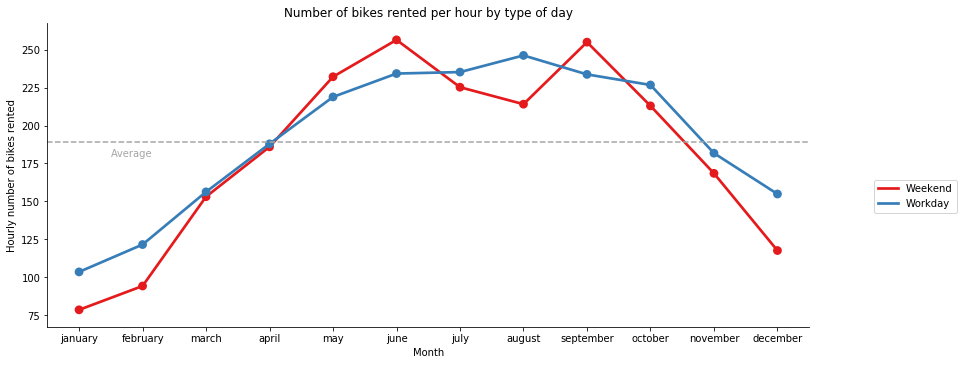

In [12]:
sns.catplot(
    x="month",
    y="total_count",
    kind="point",
    hue="is_workingday",
    data=hour,
    ci=None,
    palette="Set1",
    aspect=2.3,
    legend=False,
)
plt.legend(("Weekend", "Workday"), loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Month")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by type of day")
plt.axhline(hour.total_count.mean(), ls="--", color="#a5a5a5")
plt.text(0.5, hour.total_count.mean() - 10, "Average", color="#a5a5a5")

Text(0.5, 159.46308763450142, 'Average')

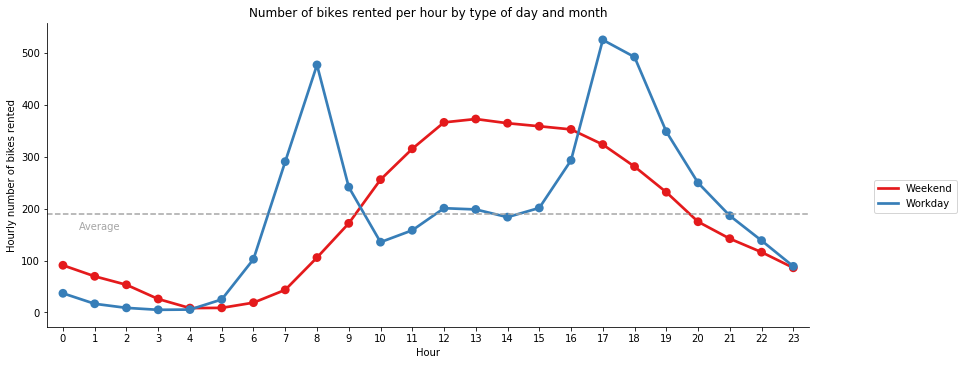

In [13]:
sns.catplot(
    x="hour",
    y="total_count",
    kind="point",
    hue="is_workingday",
    data=hour,
    ci=None,
    palette="Set1",
    aspect=2.3,
    legend=False,
)
plt.legend(("Weekend", "Workday"), loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Hour")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by type of day and month")
plt.axhline(hour.total_count.mean(), ls="--", color="#a5a5a5")
plt.text(0.5, hour.total_count.mean() - 30, "Average", color="#a5a5a5")

## Boxplots (Outliers)<a class="anchor" id="3.3"></a>

Box plots are useful for getting an idea of the distribution of numerical features and detect potential outliers. Therefore, we use different box plots to see the different distributions of `total_count`, `casual` and `registrered`. It is clear that each variable has outliers, we deal with them in the Chapter Preprocessing.

Text(0.5, 1.0, 'Boxplots of count variables')

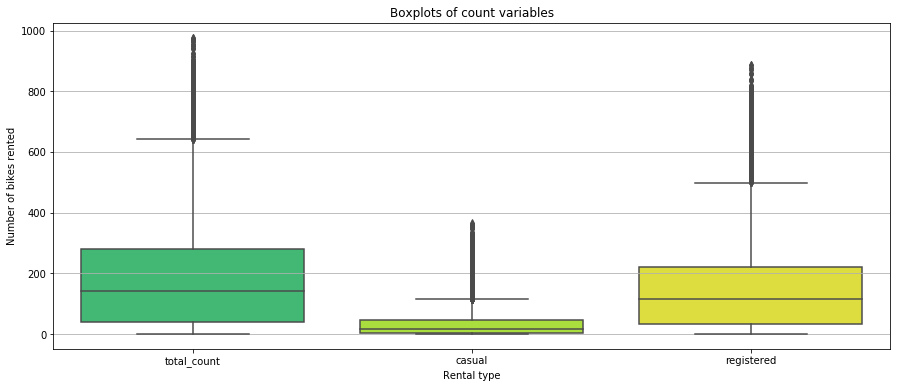

In [14]:
plt.subplots(figsize=(15, 6))
sns.boxplot(
    data=hour[["total_count", "casual", "registered"]],
    palette=["#2ecc71", "#b4f724", "#f7f725"],
)
plt.grid(which="major", axis="y")
plt.xlabel("Rental type")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of count variables")

Additionally, we created box plot for the weather variables with the same purpose of the previous ones.

Text(0.5, 1.0, 'Boxplots of weather variables')

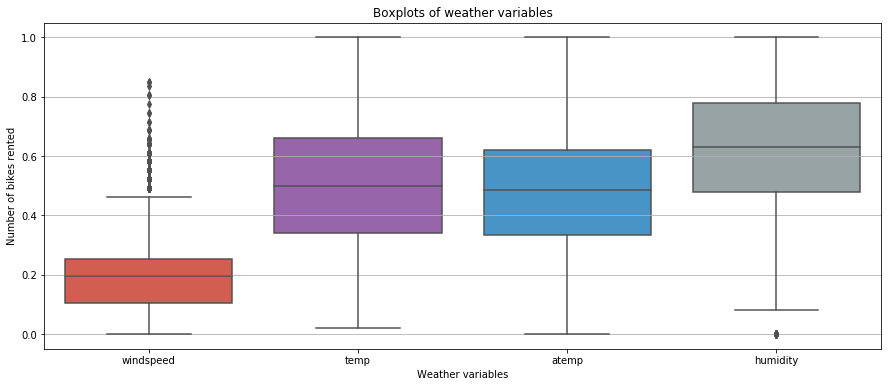

In [15]:
plt.subplots(figsize=(15, 6))
sns.boxplot(
    data=hour[["windspeed", "temp", "atemp", "humidity"]],
    palette=["#e74c3c", "#9b59b6", "#3498db", "#95a5a6"],
)
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

## Relationships Between Variables<a class="anchor" id="3.4"></a>

Another important step in the EDA, before feature engineering, is to see what the relationship is between potential predicting variables and the target variable. This gives us an idea of what features might be important for including in the model.

Text(0.5, 1.0, 'Correlations of variables with target variable')

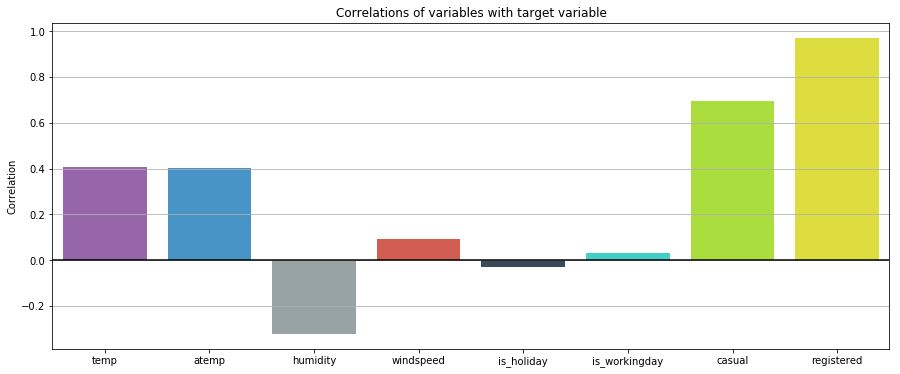

In [16]:
plt.subplots(figsize=(15, 6))
corr = hour[
    [
        "temp",
        "atemp",
        "humidity",
        "windspeed",
        "is_holiday",
        "is_workingday",
        "casual",
        "registered",
    ]
].corrwith(hour["total_count"])
sns.barplot(
    x=corr.index,
    y=corr,
    palette=[
        "#9b59b6",
        "#3498db",
        "#95a5a6",
        "#e74c3c",
        "#34495e",
        "#2be5dc",
        "#b4f724",
        "#f7f725",
    ],
)
plt.axhline(-0, 0, color="black")
plt.grid(which="major", axis="y")
plt.ylabel("Correlation")
plt.title("Correlations of variables with target variable")

We can conclude that casual and registered bike rents are strongly correlated with the `total_count`, which makes sense because together they make up for the target variable. Other strongly correlated variables are `temp` and `atemp`.

Text(0.5, 1.0, 'Correlation Matrix')

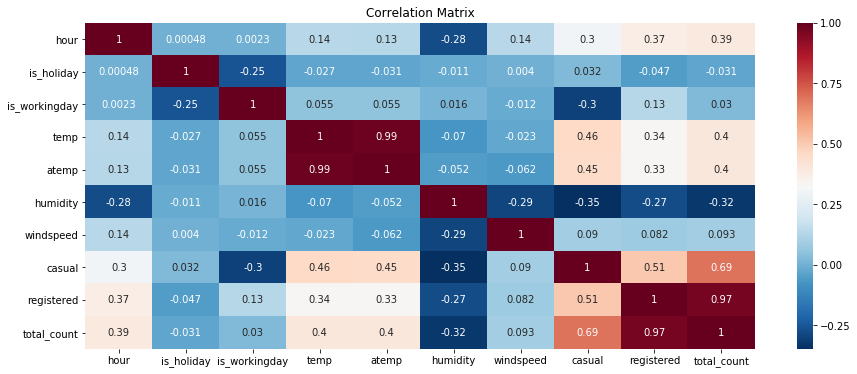

In [17]:
plt.figure(figsize=(15, 6))
sns.heatmap(hour.corr(), cmap="RdBu_r", vmax=1, annot=True)
plt.title("Correlation Matrix")

Clearly, from above heatmap, we can se that the dataset has multicolinearity. `temp` and `atemp` are highly correlated.
Will need to drop one of them.

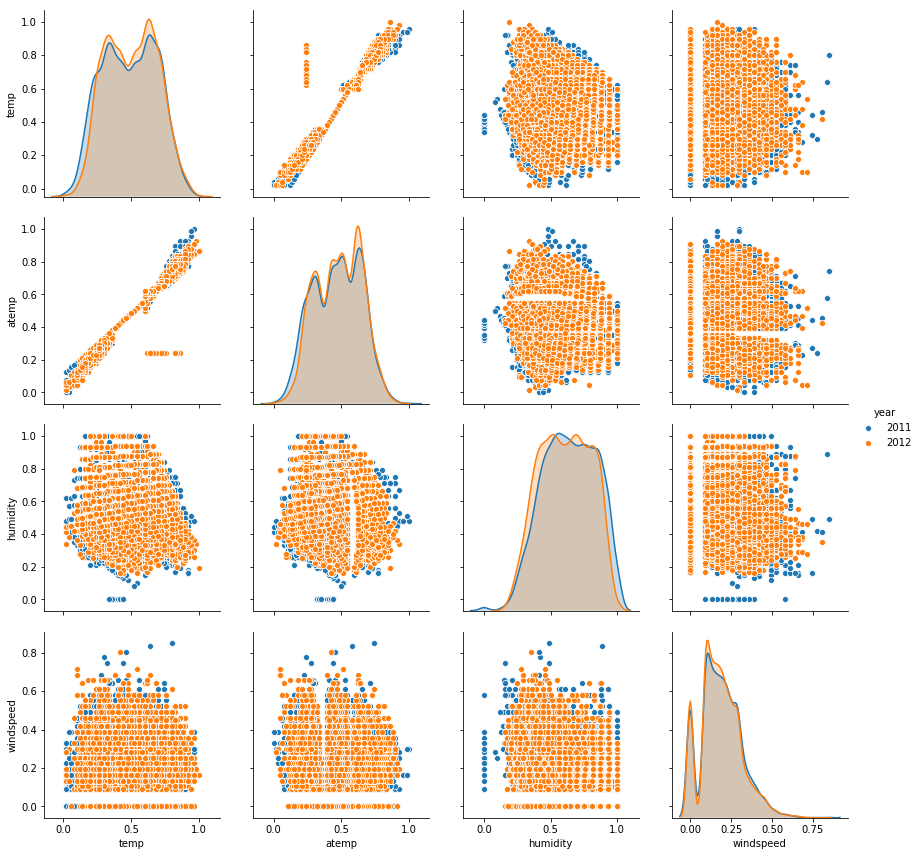

In [18]:
# Visualize the relationship among all continous variables using pairplots
NumericFeatureList = ["temp", "atemp", "humidity", "windspeed"]
sns.pairplot(hour, hue="year", vars=NumericFeatureList, height=3)

As we can see looking at the EDA and inspecting the datasets, the `hour` dataset holds the same information than `day` and with a lot more detail. Therefore we have decided to continue the analysis using onlt `hour` as our data.

# Feature Engineering<a class="anchor" id="4"></a>

## Variable Creation<a class="anchor" id="4.1"></a>

### Average Activity<a class="anchor" id="4.1.1"></a>

As seen in the EDA, rentals increase and decrease depending on the time of the day. Hence, we decided to bin the `hour` variable into three categories: `sleep_hours`, `work_hours` and `free_hours`.

According to a study made by Fortune.com, the average hours where citizens of Washington D.C. are asleep are from 11:30pm to 7:20am.

For `sleep_hours` we stretched that range a little more on the lower side because we think that even if people are not asleep per se, they might be home already since 9:00pm.

As for `work_hours` we used the regular work schedule in the US, consisting of 8 hours, from 9:00 to 17:00 during the working days.

And lastly `free_hours` consists of anything in between the last two during working days and everything but `sleep_hours` during the weekends.

_Source: http://fortune.com/2015/07/07/cities-sleep-patterns-health/_

In [19]:
sleep_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
work_hours = [9, 10, 11, 12, 13, 14, 15, 16]
free_hours = [7, 8, 17, 18, 19, 20]

average_activity = pd.DataFrame(
    np.zeros((hour.shape[0], 1)), index=hour.index, columns=["average_activity"]
)
average_activity[hour.hour.isin(sleep_hours)] = "sleep_hours"
average_activity[
    (hour.hour.isin(work_hours)) & (hour.is_workingday == 1)
] = "work_hours"
average_activity[
    (hour.hour.isin(work_hours)) & (hour.is_workingday == 0)
] = "free_hours"
average_activity[hour.hour.isin(free_hours)] = "free_hours"
average_activity = average_activity.to_sparse()
hour["average_activity"] = average_activity
print("Unique values in 'average_activity': {}".format(hour.average_activity.unique()))

Unique values in 'average_activity': ['sleep_hours' 'free_hours' 'work_hours']


### Commute Schedule<a class="anchor" id="4.1.2"></a>

We realized that during working days, most people could use the bike rentals to commute to work, therefore we created a new variable `is_commute`.

We took into consideration the rush commute hours in Washington D.C. accordint to a study by TripSavvy.com where they explain that the most common commute times in the city are from 6 a.m. to 9:30 a.m. and 3:30 p.m. to 6:30 p.m.

We used these timeframes to create the new variable taking into account the day of the week as well, since rush hour happens mostly from Monday to Friday.

_Source: https://www.tripsavvy.com/driving-times-from-dc-1040439_

In [20]:
commute_hours = [6, 7, 8, 9, 15, 16, 17, 18]

is_commute = pd.DataFrame(
    np.zeros((hour.shape[0], 1)), index=hour.index, columns=["is_commute"]
)
is_commute[(hour.hour.isin(commute_hours)) & (hour.is_workingday == 1)] = 1
is_commute = is_commute.to_sparse()
hour["is_commute"] = is_commute
hour.is_commute.unique()
print("Unique values in 'is_commute': {}".format(hour.is_commute.unique()))

Unique values in 'is_commute': [0. 1.]


### Computed Apparent Temperature<a class="anchor" id="4.1.3"></a>

We also saw that one of the most influencial factors for outdoor activities is the Wind Chill factor, meaning the temperature felt by the body as a result of wind speed and actual measured temperature.

The perceived temperature due to wind chill is lower than the actual air temperature for all temperature values where the formula used is valid (-50°F to 50°F).

Therefore we proceed to calculate the `wind_chill` variable given the formula:
<br/>
<br/>
<br/>
$$Wind Chill Temperature = 35.74 + 0.6215×Temp - 35.75×Wind^{0.16} + 0.4275×Temp×Wind^{0.16}$$
<br/>
<br/>
Note that all of the values are in Farenheit and miles per hour, so first of all we have to convert our values to those metrics.

_Source: http://mentalfloss.com/article/26730/how-wind-chill-calculated_

In order to do this, since our values are normalized we have to undo this, luckily we have the min and max values used for each normalization in the dataset description, being:
- min = -8, max = +39 for `temp`
- min = -16, max = +50 for `atemp`
- min = 0, max = +67 for `windspeed`

We will do this by using `MinMaxScaler` to set the range of values using the minimum and maximum above.

In [21]:
temp_x = MinMaxScaler(feature_range=(-8, 39)).fit_transform(pd.DataFrame(hour.temp))
hour["temp_x"] = temp_x
atemp_x = MinMaxScaler(feature_range=(-16, 50)).fit_transform(pd.DataFrame(hour.atemp))
hour["atemp_x"] = atemp_x
windspeed_x = MinMaxScaler(feature_range=(0, 67)).fit_transform(
    pd.DataFrame(hour.windspeed)
)
hour["windspeed_x"] = windspeed_x

Now we convert those values to the desired ones for the formula using:
<br/>
<br/>
<br/>
$$(°C × 9/5) + 32 = °F$$

$$ kmh / 1.609 = mph $$
<br/>
<br/>

In [22]:
hour["temp_x"] = (temp_x * 9 / 5) + 32
hour["atemp_x"] = (atemp_x * 9 / 5) + 32
hour["windspeed_x"] = windspeed_x / 1.609

We can now proceed to calculating the `wind_chill` variable for our data.

In [23]:
35.74 + 0.6215 * 48.677551 - 35.75 * (12.418318 ** 0.16) + 0.4275 * 48.677551 * (
    12.418318 ** 0.16
)

43.63624206981773

In [24]:
hour["wind_chill"] = (
    35.74
    + 0.6215 * hour.temp_x
    - 35.75 * (hour.windspeed_x ** 0.16)
    + 0.4275 * hour.temp_x * (hour.windspeed_x ** 0.16)
)

On the other hand we have the heat index effect, which is the opposite of the wind chill effect. Meaning that it estimates the temperature felt by the body as a result of air temperature and relative humidity. Heat index is often referred to as humiture.

We will now create the variable `heat_index` using the following formula:
<br/>
<br/>
<br/>
$$HeatIndex = -42.379 + 2.04901523*Temp + 10.14333127*Hum - 0.22475541*Temp*Hum - 6.83783*10^{-3}*Temp^2-5.481717*10^{-2}*Hum^2+1.22874*10^{-3}*Temp^2*Hum + 8.5282*10^{-4}*Temp*Hum^2 - 1.99*10^{-6}*Temp^2*Hum^2$$
<br/>
<br/>
<br/>
_Source: https://weather.com/safety/heat/news/heat-index-feels-like-temperature-summer_

In [25]:
hour["heat_index"] = (
    -42.379
    + 2.04901523 * hour.temp_x
    + 10.14333127 * hour.humidity
    - 0.22475541 * hour.temp_x * hour.humidity
    - 6.83783 * (10 ** -3) * (hour.temp_x ** 2)
    - 5.481717 * (10 ** -2) * (hour.humidity ** 2)
    + 1.22874 * (10 ** -3) * (hour.temp_x ** 2) * hour.humidity
    + 8.5282 * (10 ** -4) * hour.temp_x * (hour.humidity ** 2)
    - 1.99 * (10 ** -6) * (hour.temp_x ** 2) * (hour.humidity ** 2)
)

Now that we have `wind_chill` and `heat_index` we can proceed to calculate our version of apparent temperature or the temperature actually felt by the human body. Since the wind chill effect only happens when **[temperature < 35°F and windspeed > 5 mph]**, and the heat index effect only happens when **[temperature > 80°F and humidity > 40%]** we will create a new variable `atemp_x` taking into consideration this conditions and projecting the value of `atemp` otherwise.

<table><tr>
<td> <img src="https://d26tpo4cm8sb6k.cloudfront.net/img/wind-chill-old.png" alt="Wind Chill Chart" style="width: 500px;"/> </td>
<td> <img src="https://climate.ncsu.edu/images/climate/heat_index_stull.jpg" alt="Heat Index Chart" style="width: 500px;"/> </td>
</tr></table>

In [26]:
atemp_comp = hour.atemp_x.copy()
atemp_comp[(hour.temp_x <= 35) & (hour.windspeed_x >= 5)] = hour.wind_chill
atemp_comp[(hour.temp_x >= 80) & (hour.humidity >= 0.4)] = hour.heat_index
atemp_comp = atemp_comp.to_sparse()
hour["atemp_comp"] = atemp_comp

Now that we have our own apparent temperature that takes into consideration wind chill and the heat index, we will proceed to normalize it and drop the temporary variables in the next steps.

---

# Preprocessing<a class="anchor" id="5"></a>

## Scaling and Normalizing<a class="anchor" id="5.1"></a>

We will rescale variables `atemp_comp`, `registered` and `casual` just in case we decide to include them in the analysis later on using `MinMaxScaler`.

In [27]:
hour.registered = MinMaxScaler().fit_transform(pd.DataFrame(hour.registered))
hour.casual = MinMaxScaler().fit_transform(pd.DataFrame(hour.casual))
hour.atemp_comp = MinMaxScaler().fit_transform(pd.DataFrame(hour.atemp_comp))

## Handling Outliers<a class="anchor" id="5.2"></a>

Even though, `windspeed` and `humidity` have been normalized prior to the data ingestion, if data contains outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases,it is better to use `robust_scale` and `RobustScaler` as drop-in replacements instead. They use more robust estimates for the center and range of the data.

In [28]:
# This didn't work :(

# hour.windspeed = robust_scale(hour.windspeed, axis=0)
# hour.humidity = robust_scale(hour.humidity, axis=0);

### Clipping Outliers<a class="anchor" id="5.2.1"></a>

Since the outliers remain after the normalization, we can now proceed if it is viable to remove them or just clip them to any range of interquartiles.

Text(0.5, 1.0, 'Boxplots of weather variables')

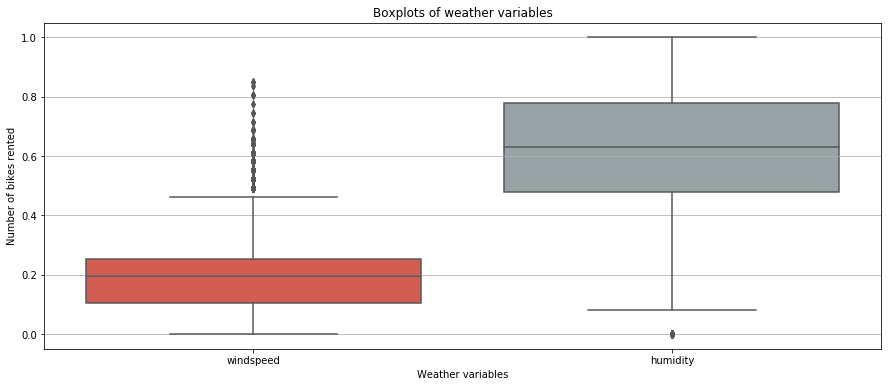

In [29]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=hour[["windspeed", "humidity"]], palette=["#e74c3c", "#95a5a6"])
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

[]

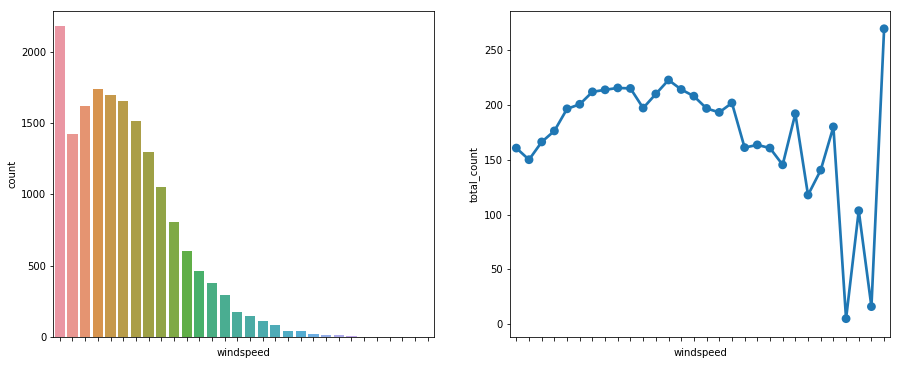

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(hour.windspeed, ax=ax1)
sns.pointplot(x="windspeed", y="total_count", data=hour, ci=None, ax=ax2)
ax1.set_xticklabels([])
ax2.set_xticklabels([])

As we can see above, the outliers do seem to skew the data a little bit, and the percentage of rows that contain outliers seems to be small enough to remove them safely. We now proceed to remove those outliers. We will first try to clip them to the .98 IQR for `windspeed` and to the 0.01 IQR for `humidity` since they seem to the thresholds to remove the outliers.

In [31]:
# # We got this thresholds through trial and error.
hour.windspeed[
    hour.windspeed > hour.windspeed.quantile(0.98)
] = hour.windspeed.quantile(0.98)
hour.humidity[hour.humidity < hour.humidity.quantile(0.01)] = hour.humidity.quantile(
    0.01
)

Text(0.5, 1.0, 'Boxplots of weather variables')

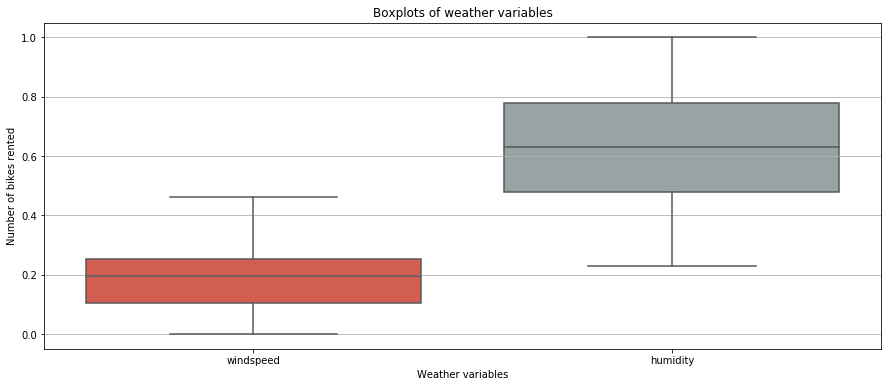

In [32]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=hour[["windspeed", "humidity"]], palette=["#e74c3c", "#95a5a6"])
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

Now the outliers have been removed by forcing their values inside the respective IQR for each variable.

[]

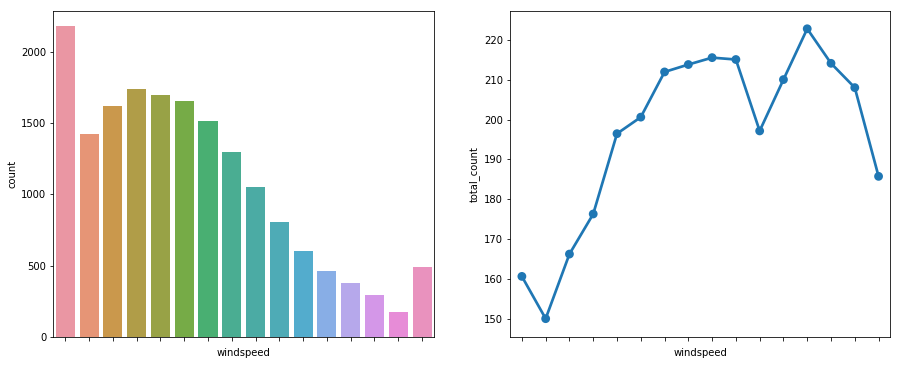

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(hour.windspeed, ax=ax1)
sns.pointplot(x="windspeed", y="total_count", data=hour, ci=False, ax=ax2)
ax1.set_xticklabels([])
ax2.set_xticklabels([])

### Other Outliers<a class="anchor" id="5.2.2"></a>

Something that we should note is that in October 2012, there is a huge drop in the quantity of bikes rented at the end of the month. As we can see in the graph below, `total_count` drops to 0 on a particular day (October 29).

After some research we concluded that this is not an error in the data, but since was updated in real time with no filters, we found out that that particular day Washington D.C. was hit by Hurricane Sandy and therefore the rentals droped to zero.

_Source: https://www.telegraph.co.uk/news/worldnews/northamerica/usa/9642980/Hurricane-Sandy-October-29-as-it-happened.html_

Text(23.5, 210, 'Hurricane Sandy -->')

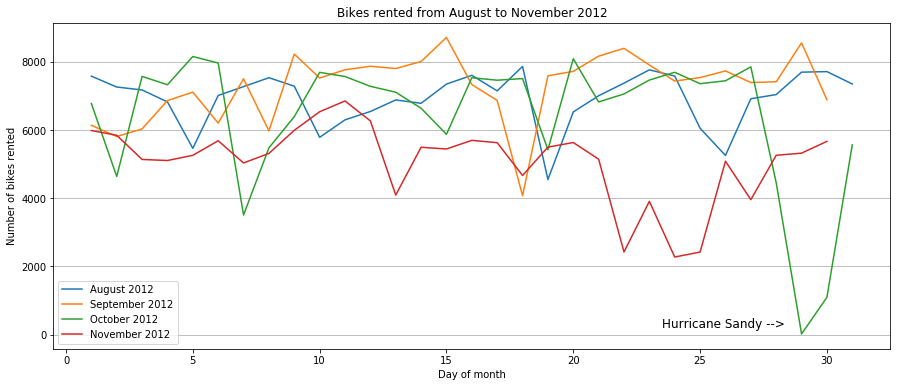

In [34]:
aug_2012 = day[(day.year == "2012") & (day.month == "august")]
sep_2012 = day[(day.year == "2012") & (day.month == "september")]
oct_2012 = day[(day.year == "2012") & (day.month == "october")]
nov_2012 = day[(day.year == "2012") & (day.month == "november")]

day_30 = np.arange(1, 31)
day_31 = np.arange(1, 32)

plt.subplots(figsize=(15, 6))
sns.lineplot(x=day_31, y="total_count", data=aug_2012)
sns.lineplot(x=day_30, y="total_count", data=sep_2012)
sns.lineplot(x=day_31, y="total_count", data=oct_2012)
sns.lineplot(x=day_30, y="total_count", data=nov_2012)
plt.legend(labels=["August 2012", "September 2012", "October 2012", "November 2012"])
plt.xlabel("Day of month")
plt.ylabel("Number of bikes rented")
plt.title("Bikes rented from August to November 2012")
plt.grid(axis="y")
plt.text(23.5, 210, "Hurricane Sandy -->", color="black", size=12)

This might not affect our results in a significant way, but since this event is non recurring and will not repeat in the future in a predicted way, we consider this to be an outlier. We will proceed to impute it with the mean for that specific month later on.

In [35]:
sept_annual_increase = (
    day.total_count[(day.month == "september") & (day.year == "2012")].mean()
    / day.total_count[(day.month == "september") & (day.year == "2011")].mean()
)

sept_annual_increase

1.7154012776844716

For this imputation we first computed the mean increase in September, considering it is the most similar to October. Then we took the previous year's values and added the increment to them.

In [36]:
hour.total_count[hour.datetime.isin(["2012-10-28", "2012-10-29", "2012-10-30"])] = (
    hour.total_count[
        hour.datetime.isin(["2011-10-28", "2011-10-29", "2011-10-30"])
    ].mean()
    * sept_annual_increase
)

hour.registered[hour.datetime.isin(["2012-10-28", "2012-10-29", "2012-10-30"])] = (
    hour.registered[
        hour.datetime.isin(["2011-10-28", "2011-10-29", "2011-10-30"])
    ].mean()
    * sept_annual_increase
)

hour.casual[hour.datetime.isin(["2012-10-28", "2012-10-29", "2012-10-30"])] = (
    hour.casual[hour.datetime.isin(["2011-10-28", "2011-10-29", "2011-10-30"])].mean()
    * sept_annual_increase
)

## Droping Variables<a class="anchor" id="5.3"></a>

We decided to drop the columns `casual` and `registered` since we are only interested in the `total_count` and they are so correlated that can cause overfitting.

`temp` is also extremely correlated with `atemp`, but since we believe `atemp` has much more effect on the target variable, we decided to keep that one.

**Update: we get better scores with `temp` so we will leave it.


Besides having `temp` embedded, `atemp` also comprises `humidity` and `windspeed`, but since they are not as correlated in the matrix we decided to leave them.

><font size=2, color=black>_Apparent temperature is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed. The measure is most commonly applied to the perceived outdoor temperature._</font>

We expect that the vatiables `average_activity` and `is_commute` created above will emprise all the information conveyed in `hour`, but since scores are higher with it we decided to leave it.


We will also drop all variables used to compute our `atemp_comp` variable.

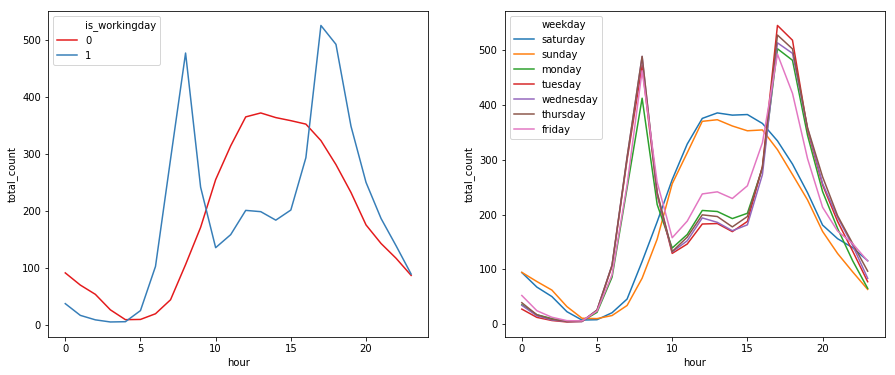

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(
    x="hour",
    y="total_count",
    hue="is_workingday",
    data=hour,
    ci=None,
    palette="Set1",
    ax=ax1,
)

sns.lineplot(x="hour", y="total_count", hue="weekday", data=hour, ci=None, ax=ax2)

In [38]:
hour.columns

Index(['datetime', 'season', 'year', 'month', 'hour', 'is_holiday', 'weekday',
       'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'total_count', 'average_activity',
       'is_commute', 'temp_x', 'atemp_x', 'windspeed_x', 'wind_chill',
       'heat_index', 'atemp_comp'],
      dtype='object')

In [39]:
hour.drop(
    columns=[
        "casual",
        "registered",
        "temp_x",
        "windspeed_x",
        "wind_chill",
        "heat_index",
        "atemp_x",
    ],
    inplace=True,
)

## One Hot Encoder<a class="anchor" id="5.4"></a>

First we check the data to see which variables will be dummified, in this case they are: `season`, `year`, `month`, `weather_condition` and `average_activity`.

In [40]:
cat_variables = hour.dtypes[hour.dtypes == "object"].index
cat_variables

Index(['season', 'year', 'month', 'weekday', 'weather_condition',
       'average_activity'],
      dtype='object')

Now we proceed to dummify the selected variables to be able to be used in our models.

In [41]:
hour = pd.get_dummies(hour, columns=cat_variables)
print("The dataset now contains {} columns.".format(hour.shape[1]))

The dataset now contains 43 columns.


## Skewness<a class="anchor" id="5.5"></a>

Now we will check if there is any skewness in our target variable, if so we will proceed to take the log in order to make it normally distributed.

Text(0.5, 1.0, 'Distribution of Total Count')

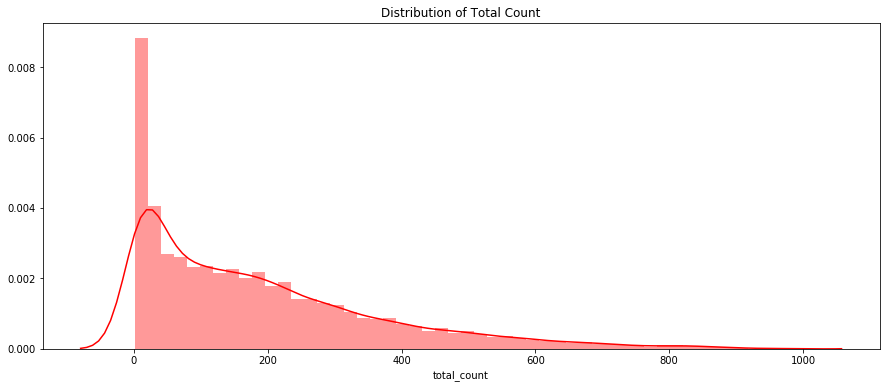

In [42]:
plt.subplots(figsize=(15, 6))
sns.distplot(hour.total_count, color="red")
plt.title("Distribution of Total Count")

In [43]:
hour.total_count = np.log1p(hour.total_count)

As we can see, now the distribution of the target variable looks much more like a normally distributed one. This will help since several models we will use in our analysis do not perform well with skewed data.

Text(0.5, 1.0, 'Distribution of Log-transformed Total Count')

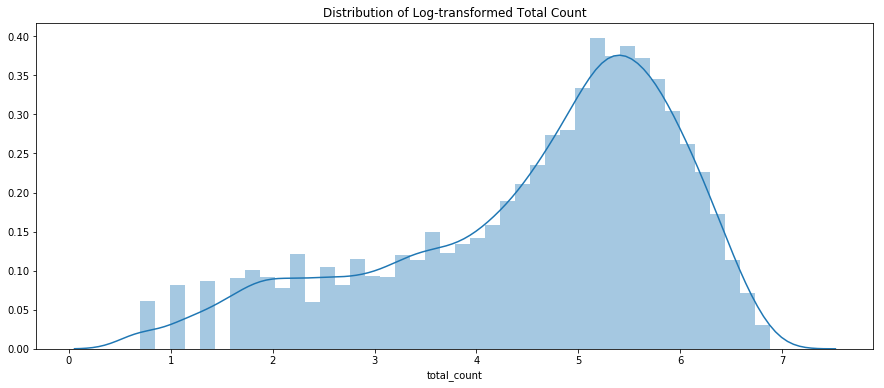

In [44]:
plt.subplots(figsize=(15, 6))
sns.distplot(hour.total_count)
plt.title("Distribution of Log-transformed Total Count")

## Train / Test Split<a class="anchor" id="5.6"></a>

We will now proceed to split the dataset into `train` and `test`. Since this is a time series dataset, we have to account for the order on which events happened, therefore we will train the models with the whole first year and the first three quarters of the second year, and use the last quarter as test data to evaluate the models.

The fourth quarter begins in October 1st, therefore we set the cutoff point for our split on 2012/10/01.

In [45]:
# This is where the 4th quarter of 2012 begins (our test set)
hour[hour.datetime == "2012/10"].head(1).index[0]

15212

In [46]:
train = hour[: 15212 - 1]
test = hour[15212 - 1 :]

In [47]:
print(
    "The training dataset consists of {} rows, {}% of the data.".format(
        train.shape[0], round(train.shape[0] / hour.shape[0] * 100, 2)
    )
)
print(
    "The test dataset consists of {} rows, {}% of the data.".format(
        test.shape[0], round(test.shape[0] / hour.shape[0] * 100, 2)
    )
)

The training dataset consists of 15211 rows, 87.53% of the data.
The test dataset consists of 2168 rows, 12.47% of the data.


Dropping the `datetime` variable since it has no use for us for now. We will add it back later when we use time series techniques.

In [48]:
train.drop(columns="datetime", inplace=True)
test.drop(columns="datetime", inplace=True)

We divide the datasets into `X_train`, `X_test`, `y_train` and `y_test` to fit the models.

In [49]:
X_train, X_test, y_train, y_test = (
    train.drop(columns="total_count"),
    test.drop(columns="total_count"),
    train["total_count"],
    test["total_count"],
)

We also divide the whole dataset to het our predictor variables `X` and our target variable `y` to use for cross validation.

In [50]:
X, y = hour.drop(columns=["datetime", "total_count"]), hour["total_count"]

---

# Modeling<a class="anchor" id="6"></a>

We will now proceed to the modeling part, where we will make use of various models starting with the most simple ones and gradually increasing its complexity. We will include first a time series analysis,  linear models and then move to non-linear models.

## Time Series Analysis<a class="anchor" id="6.1"></a>

In [51]:
timeseries = day[["datetime", "registered"]].copy()
timeseries.head()

,datetime,registered
instant,,
1,2011-01-01,654
2,2011-01-02,670
3,2011-01-03,1229
4,2011-01-04,1454
5,2011-01-05,1518


### Visualizing Data<a class="anchor" id="6.1.1"></a>

We start by plotting the data in order to visualize it better. Then, we split the graph into four different graphs: "Observed", "Trend", "Seasonal" and "Residuals" to extract more information for the graph and choose the appropriate model.

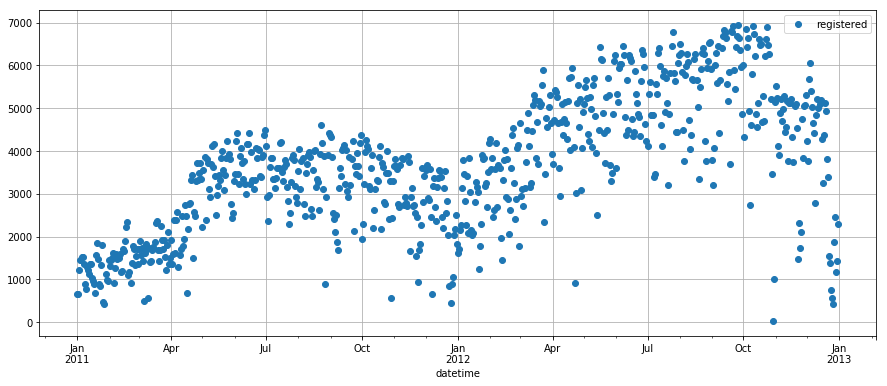

In [52]:
timeseries.plot(x="datetime", y="registered", style="o", figsize=(15, 6))
plt.grid()

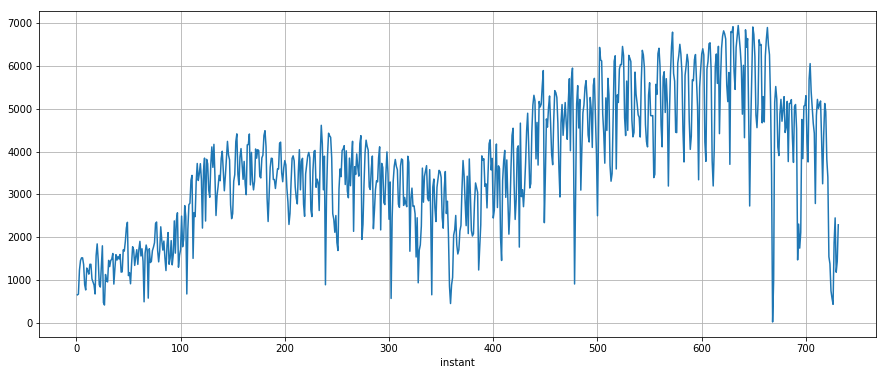

In [53]:
cnt = timeseries["registered"]
date_range = pd.date_range("2011-01-01", "2012-12-31")
cnt.plot(figsize=(15, 6))
plt.grid()

Here we split the graph into the different parts mentioned above.

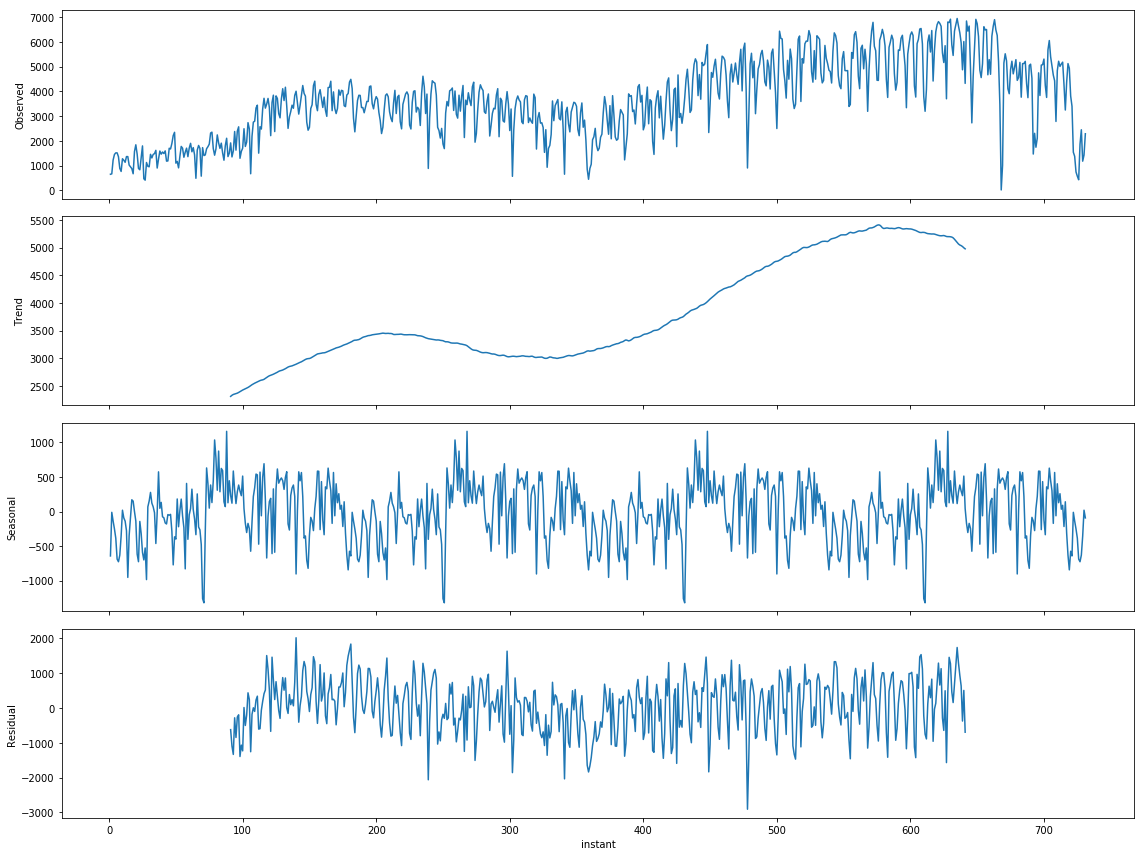

In [54]:
rcParams["figure.figsize"] = 16, 12
decomposition = sm.tsa.seasonal_decompose(cnt, freq=180)
fig = decomposition.plot()
plt.show()

### Forecasting with SARIMA<a class="anchor" id="6.1.2"></a>

After visualizing the data, we have to choose the best model to predict this time series. To do that, we define the parameters and get all the SARIMA models that we can use and then we choose the best one based on the AIC score (we choose the one with the smallest AIC score).

In [55]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [56]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                cnt,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = mod.fit()
            print("ARIMA{}x{}7 - AIC:{}".format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:14174.691517122956
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:13619.729580108076
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:12132.15716237777
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:11776.543714382111
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:12137.234358721023
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:11888.222414065021
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:11850.18989094922
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:11771.63629927352
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:13664.819319187101
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:12842.691448608915
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:11984.302335209783
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:11575.03459018594
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:11997.65419958186
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:11686.17741762669
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:11697.88911389043
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:11572.662859626203
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:11993.566339090237
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:11857.299724199345
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:

The above output suggests that ARIMA(1, 1, 1)x(1, 1, 1, 7) yields the lowest AIC value of 11402.488116477281. Therefore we should consider this to be optimal option.

### Fitting the SARIMA Model<a class="anchor" id="6.1.3"></a>

After getting the optimal SARIMA model, we fit it and plot the diagnostics to get a better understanding of the model.

In [57]:
mod = sm.tsa.statespace.SARIMAX(
    cnt,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4450      0.039     11.380      0.000       0.368       0.522
ma.L1         -0.9103      0.024    -37.821      0.000      -0.957      -0.863
ar.S.L7       -0.0604      0.044     -1.362      0.173      -0.147       0.026
ma.S.L7       -0.9290      0.017    -55.889      0.000      -0.962      -0.896
sigma2      4.913e+05   1.35e+04     36.264      0.000    4.65e+05    5.18e+05


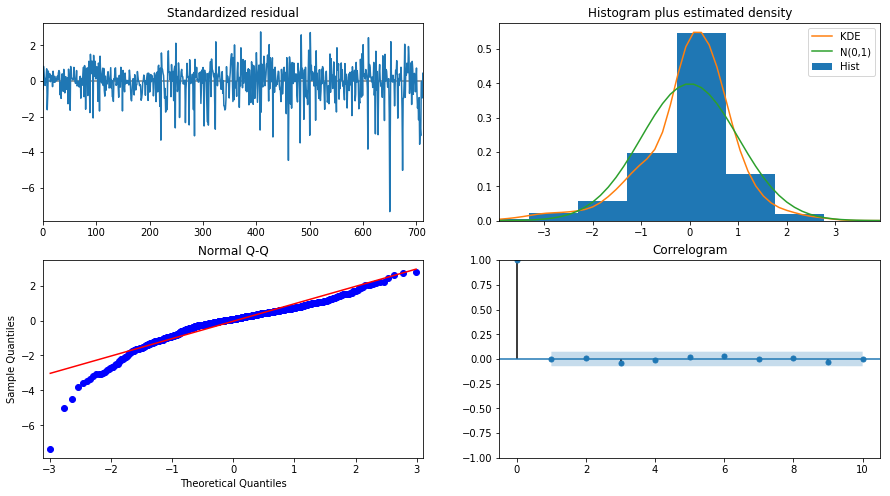

In [58]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

### Validating Forecasts<a class="anchor" id="6.1.4"></a>

We plot the observed data and the one-step ahead forecast

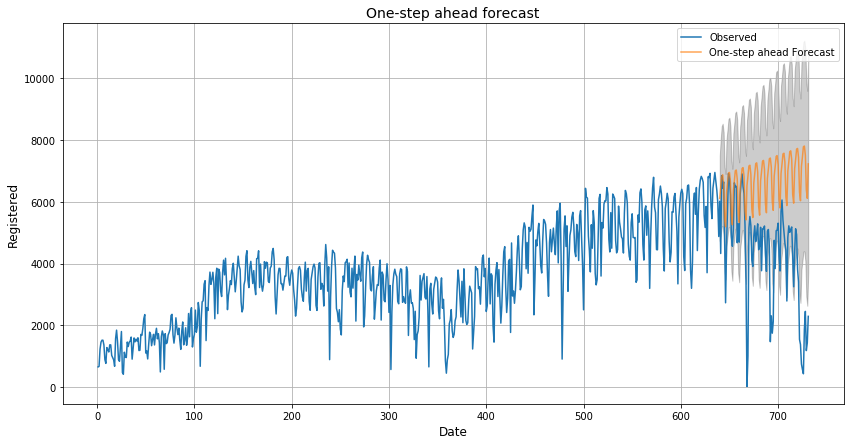

In [59]:
pred = results.get_prediction(start=timeseries.index.get_loc(640), dynamic=True)
pred_ci = pred.conf_int()
ax = cnt[0:].plot(label="Observed")
pred.predicted_mean.plot(
    ax=ax, label="One-step ahead Forecast", alpha=0.7, figsize=(14, 7)
)
ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=0.2
)
plt.title("One-step ahead forecast", size=14)
ax.set_xlabel("Date", size=12)
ax.set_ylabel("Registered", size=12)
plt.legend()
plt.grid()
plt.show()

In [60]:
cnt_forecasted = pred.predicted_mean
cnt_truth = cnt[700:]
mse = ((cnt_forecasted - cnt_truth) ** 2).mean()
print("The Mean Squared Error of our forecasts is {}".format(round(mse, 2)))

The Mean Squared Error of our forecasts is 14543856.76


In [61]:
print(
    "The Root Mean Squared Error of our forecasts is {}".format(round(np.sqrt(mse), 2))
)

The Root Mean Squared Error of our forecasts is 3813.64


In [62]:
pred_ci["mid registered"] = (
    pred_ci["lower registered"] + pred_ci["upper registered"]
) / 2

In [63]:
pred_ci["weighted registered"] = (
    2 * pred_ci["lower registered"] + pred_ci["upper registered"]
) / 3

r2_weighted = r2_score(
    timeseries["registered"].tail(92), pred_ci["weighted registered"]
)
print("The R-Squared score of our forecasts is {}".format(round(r2_weighted, 5)))

The R-Squared score of our forecasts is -0.71529


In [64]:
pred_ci.head()

,lower registered,upper registered,mid registered,weighted registered
instant,,,,
640,4733.034392,7480.653776,6106.844084,5648.907520
641,4900.077964,8015.806648,6457.942306,5938.654192
642,5194.487685,8437.650612,6816.069149,6275.541994
643,5217.188997,8524.259610,6870.724304,6319.545868
644,4904.942536,8254.901220,6579.921878,6021.595431


### Producing and Visualizing Forecasts<a class="anchor" id="6.1.5"></a>

Finally, we plot the observed data until the 3rd quarter of 2012 and the predictions of the 4th quarter of 2012.

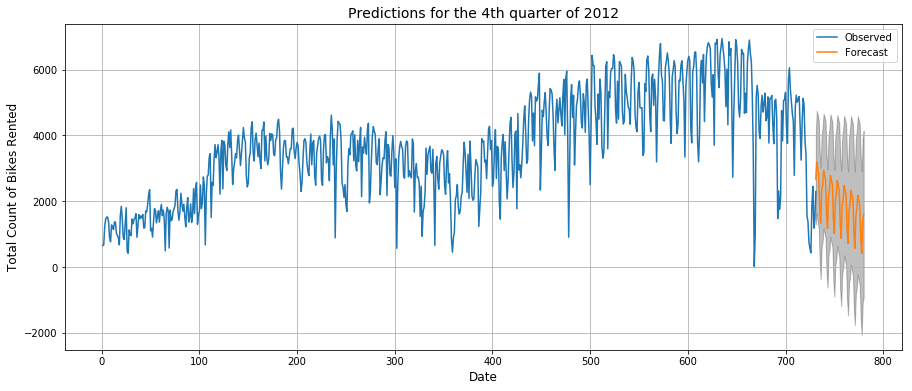

In [65]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = cnt.plot(label="Observed", figsize=(15, 6))
pred_uc.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=0.25
)
plt.title("Predictions for the 4th quarter of 2012", size=14)
ax.set_xlabel("Date", size=12)
ax.set_ylabel("Total Count of Bikes Rented", size=12)
plt.legend()
plt.grid()
plt.show()

## Linear Models<a class="anchor" id="6.2"></a>

### Linear Regression<a class="anchor" id="6.2.1"></a>

In [66]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [67]:
lr_score = round(r2_score(y_test, y_pred_lr), 4)
print("Linear Regression R2: {}".format(lr_score))

Linear Regression R2: 0.7415


In [68]:
print("Linear Regression CV R2: {}".format(round(cross_val_score(lr, X, y).mean(), 4)))

Linear Regression CV R2: 0.7338


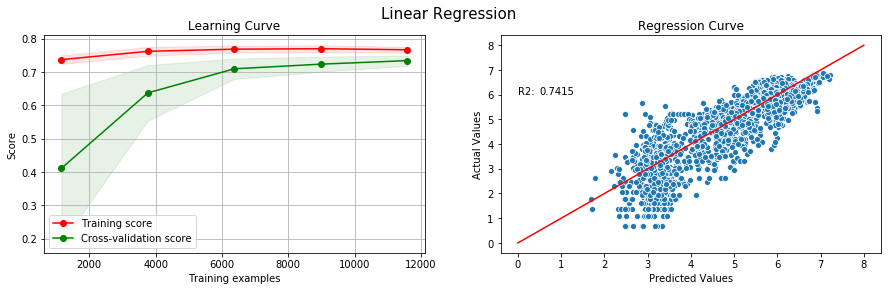

In [69]:
def lr_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(lr, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_lr, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Linear Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, lr_score)


lr_plot()

### Lasso Regression<a class="anchor" id="6.2.2"></a>

In [70]:
lasso = Lasso()
lasso_model = lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [71]:
lasso_score = round(r2_score(y_test, y_pred_lasso), 4)
print("Lasso Regression R2: {}".format(lasso_score))

Lasso Regression R2: 0.2803


In [72]:
print(
    "Lasso Regression CV R2: {}".format(round(cross_val_score(lasso, X, y).mean(), 4))
)

Lasso Regression CV R2: 0.2312


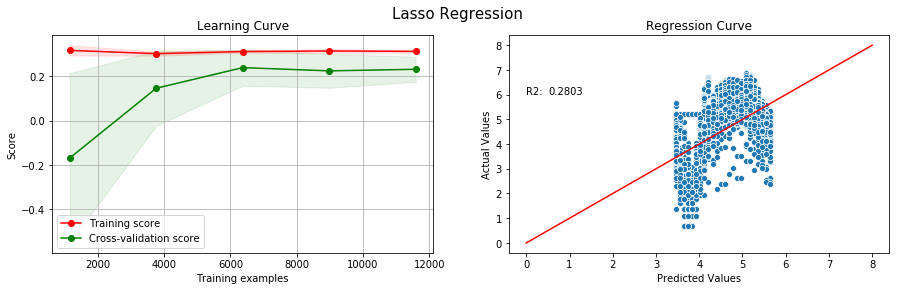

In [73]:
def lasso_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(lasso, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_lasso, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Lasso Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, lasso_score)


lasso_plot()

### Ridge Regression<a class="anchor" id="6.2.3"></a>

In [74]:
ridge = Ridge()
ridge_model = ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

In [75]:
ridge_score = round(r2_score(y_test, y_pred_ridge), 4)
print("Ridge Regression R2: {}".format(round(ridge.score(X_test, y_test), 4)))

Ridge Regression R2: 0.7413


In [76]:
print(
    "Ridge Regression CV R2: {}".format(round(cross_val_score(ridge, X, y).mean(), 4))
)

Ridge Regression CV R2: 0.7337


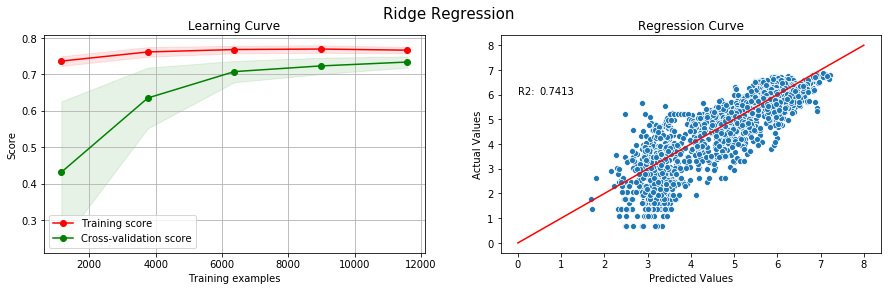

In [77]:
def ridge_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(ridge, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_ridge, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Ridge Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, ridge_score)


ridge_plot()

### ElasticNet<a class="anchor" id="6.2.4"></a>

In [78]:
net = ElasticNet()
net_model = net.fit(X_train, y_train)
y_pred_net = net.predict(X_test)

In [79]:
net_score = round(r2_score(y_test, y_pred_net), 4)
print("ElasticNet Regression R2: {}".format(net_score))

ElasticNet Regression R2: 0.286


In [80]:
print(
    "ElasticNet Regression CV R2: {}".format(
        round(cross_val_score(net, X, y).mean(), 4)
    )
)

ElasticNet Regression CV R2: 0.2386


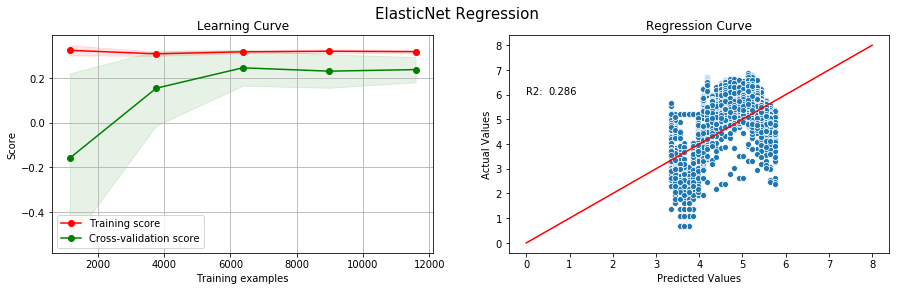

In [81]:
def net_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(net, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_net, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("ElasticNet Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, net_score)


net_plot()

### Linear SVM<a class="anchor" id="6.2.5"></a>

In [82]:
lsvm = SVR(kernel="linear", epsilon=100, C=1000)
lsvm_model = lsvm.fit(X_train, y_train)
y_pred_lsvm = lsvm.predict(X_test)

In [86]:
lsvm_score = round(r2_score(y_test, y_pred_lsvm), 4)
print("Linear SVM Regression R2: {}".format(lsvm_score))

Linear SVM Regression R2: -0.4541


In [ ]:
print(
    "Linear SVM Regression CV R2: {}".format(
        round(cross_val_score(lsvm, X, y).mean(), 4)
    )
)

Linear SVM Regression CV R2: -0.3648


In [ ]:
# param_lsvm = {"C": [10, 100, 1000], "epsilon": [0.1, 1, 10, 100]}

# lsvm_opt = GridSearchCV(SVR(kernel="linear"), param_lsvm, cv=3)

# lsvm_opt.fit(X, y)

# print(lsvm_opt.best_score_)
# print(lsvm_opt.best_params_)

# # {'C': 1000, 'epsilon': 100}

Since the basic Non-linear SVM gave us such a bad result we decided not to go ahead with its hyperparameter optimization.

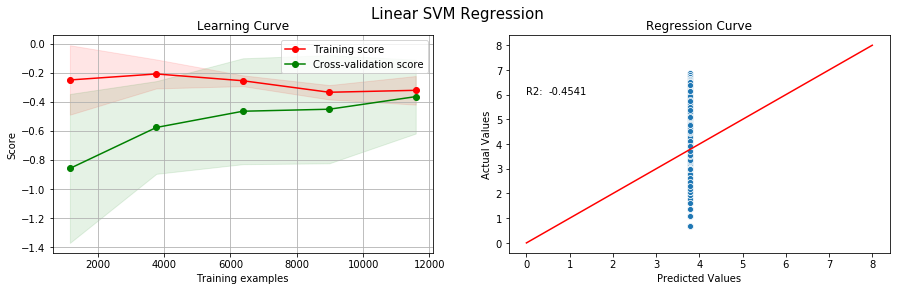

In [87]:
def lsvm_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(lsvm, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_lsvm, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Linear SVM Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, lsvm_score)


lsvm_plot()

## Non-linear Models<a class="anchor" id="6.3"></a>

### Non-linear SVM<a class="anchor" id="6.3.1"></a>

In [88]:
nlsvm = SVR(kernel="rbf", C=1000, epsilon=10)
nlsvm_model = nlsvm.fit(X_train, y_train)
y_pred_nlsvm = nlsvm.predict(X_test)

In [90]:
nlsvm_score = round(r2_score(y_test, y_pred_nlsvm), 4)
print("Non-linear SVM Regression R2: {}".format(nlsvm_score))

Non-linear SVM Regression R2: -0.4541


In [ ]:
print(
    "Non-linear SVM Regression CV R2: {}".format(
        round(cross_val_score(nlsvm, X, y).mean(), 4)
    )
)

In [ ]:
# param_nlsvm = {"C": [10, 100, 1000], "epsilon": [0.1, 1, 10, 100]}

# nlsvm_opt = GridSearchCV(SVR(kernel="rbf"), param_nlsvm, cv=3)

# nlsvm_opt.fit(X, y)

# print(nlsvm_opt.best_score_)
# print(nlsvm_opt.best_params_)

# # {'C': 1000, 'epsilon': 10}

Since the basic Non-linear SVM gave us such a bad result we decided not to go ahead with its hyperparameter optimization.

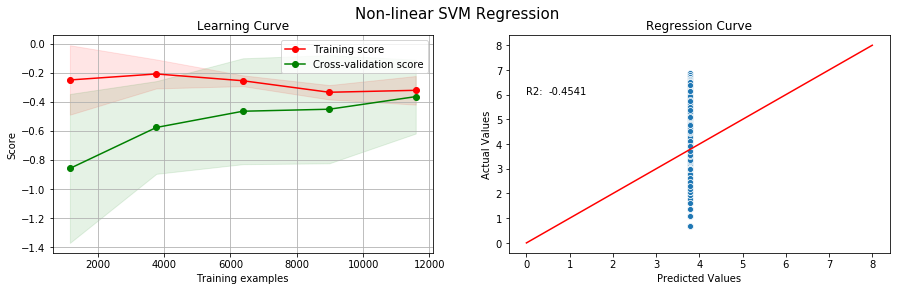

In [91]:
def nlsvm_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(nlsvm, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_nlsvm, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Non-linear SVM Regression", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, nlsvm_score)


nlsvm_plot()

### Random Forest Regressor<a class="anchor" id="6.3.2"></a>

In [92]:
rf = RandomForestRegressor(
    random_state=42,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=None,
)
rf_model = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [93]:
rf_score = round(r2_score(y_test, y_pred_rf), 4)
print("Random Forest Regressor Regression R2: {}".format(rf_score))

Random Forest Regressor Regression R2: 0.8806


In [94]:
print(
    "Random Forest Regressor Regression CV R2: {}".format(
        round(cross_val_score(rf, X, y).mean(), 4)
    )
)

Random Forest Regressor Regression CV R2: 0.8811


In [ ]:
param_rf = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [3, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 10, 18],
}

rf_opt = GridSearchCV(RandomForestRegressor(), param_rf, cv=3)

rf_opt.fit(X, y)

print(rf_opt.best_score_)
print(rf_opt.best_params_)


# {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}

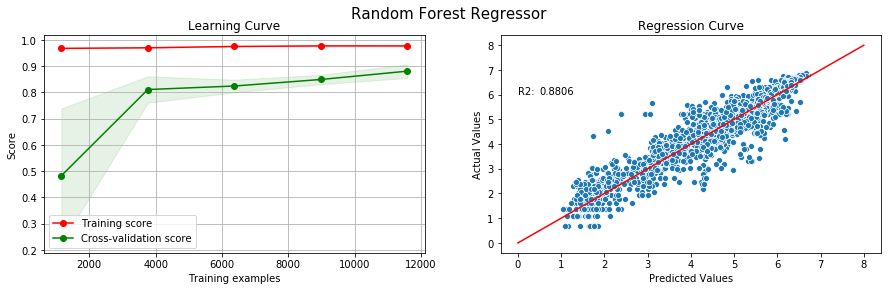

In [99]:
def rf_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(rf, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_rf, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Random Forest Regressor", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, rf_score)


rf_plot()

### Gradient Boosting Regressor<a class="anchor" id="6.3.3"></a>

In [95]:
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000)
gbr_model = gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [96]:
gbr_score = round(gbr.score(X_test, y_test), 4)
print("Gradient Boosting Regressor R2: {}".format(gbr_score))

Gradient Boosting Regressor R2: 0.9065


In [97]:
print(
    "Gradient Boosting Regressor CV R2: {}".format(
        round(cross_val_score(gbr, X, y).mean(), 4)
    )
)

Gradient Boosting Regressor CV R2: 0.9143


In [ ]:
param_gbr = {"learning_rate": [0.01, 0.1, 0.5, 0.6], "n_estimators": [10, 100, 1000]}

gbr_opt = GridSearchCV(GradientBoostingRegressor(), param_gbr, cv=3)

gbr_opt.fit(X, y)

print(gbr_opt.best_score_)
print(gbr_opt.best_params_)

# {'learning_rate': 0.1, 'n_estimators': 1000}

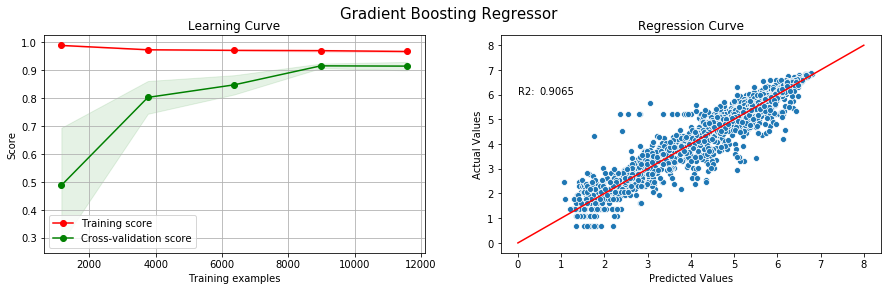

In [98]:
def gbr_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(gbr, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_gbr, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Gradient Boosting Regressor", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, gbr_score)


gbr_plot()

### XGBoost Regressor<a class="anchor" id="6.3.4"></a>

In [100]:
xgbr = XGBRegressor(max_depth=3, n_estimators=1000)
xgbr_model = xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)

In [101]:
xgbr_score = round(xgbr.score(X_test, y_test), 4)
print("XGBoost Regressor R2: {}".format(xgbr_score))

XGBoost Regressor R2: 0.9058


In [102]:
print(
    "XGBoost Regressor CV R2: {}".format(round(cross_val_score(xgbr, X, y).mean(), 4))
)

XGBoost Regressor CV R2: 0.9134


In [ ]:
param_xgbr = {"max_depth": [3, 5, 7], "n_estimators": [10, 100, 1000]}

xgbr_opt = GridSearchCV(XGBRegressor(), param_xgbr, cv=3)

xgbr_opt.fit(X, y)

print(xgbr_opt.best_score_)
print(xgbr_opt.best_params_)

# {'max_depth': 3, 'n_estimators': 1000}

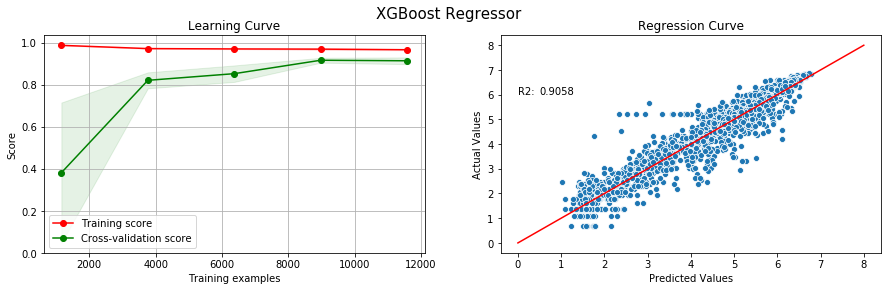

In [103]:
def xgbr_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(xgbr, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_xgbr, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("XGBoost Regressor", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, xgbr_score)


xgbr_plot()

Now that we have our optimized models, we can proceed to aggregate the results in a table to have a birdseye view of the outcomes.

In [104]:
models = ["lr", "lasso", "ridge", "lsvm", "nlsvm", "rf", "gbr", "xgbr"]
top_models = []
for model in models:
    top_models.append([model, (r2_score(y_test, eval("y_pred_" + model)))])
top_models = pd.DataFrame(top_models).sort_values(1, ascending=False)
top_models = (
    top_models.rename(columns={0: "model", 1: "r2"}).reset_index().drop(columns="index")
)
top_models

,model,r2
0,gbr,0.906512
1,xgbr,0.905758
2,rf,0.880623
3,lr,0.741521
4,ridge,0.741349
5,lasso,0.280271
6,lsvm,-0.454054
7,nlsvm,-0.454054


As we can see from all the models above, the best models are tree-based, followed by SVMs and regressions. Having this rank now we can proceed to combine the models and see if the accuracy improves.

## Model Combinations<a class="anchor" id="6.4"></a>

In this section we will use the weighted average method as well as stacking to combine the best performing models and see if they perform better together. First we will start with the weights.

### Weighted Average<a class="anchor" id="6.4.1"></a>

We define a function to find the optimal weights to assign to each model's predictions in order to maximize the predictive power while combined.

This function computes the cost the combined scores of the first five performing models.

In [122]:
def optimal_weights_top5(w1, w2, w3, w4, w5):
    """
    optimal_weights_top5(w1, w2, w3, w4, w5)

    This function takes as arguments five weights and multiplies them
    with their respective model's predictions and returns the R2 score
    for the weighted predictions.

    """
    y_pred_stacked = (
        eval("y_pred_" + top_models.model[0]) * w1
        + eval("y_pred_" + top_models.model[1]) * w2
        + eval("y_pred_" + top_models.model[2]) * w3
        + eval("y_pred_" + top_models.model[3]) * w4
        + eval("y_pred_" + top_models.model[4]) * w5
    )
    r2_stacked = r2_score(y_test, y_pred_stacked)
    return r2_stacked

Now that we have the function to calculate the scores defined, we proceed to create a loop to iterate through all possible combinations of weights that add up to 1 for five models.

(We chose five models because it is not time efficient anymore to increase the number of inputs after five)

The loop uses the function defined above to compute score the score for each possible combination of weights and appends all the weights and their respective scores to a list to be used later on.

In [123]:
lst = []
for w1 in range(0, 101):
    for w2 in range(0, 101):
        for w3 in range(0, 101):
            for w4 in range(0, 101):
                for w5 in range(0, 101):
                    if (w1 + w2 + w3 + w4 + w5) == 100:
                        lst.append(
                            [
                                optimal_weights_top5(
                                    w1 / 100, w2 / 100, w3 / 100, w4 / 100, w5 / 100
                                ),
                                w1 / 100,
                                w2 / 100,
                                w3 / 100,
                                w4 / 100,
                                w5 / 100,
                            ]
                        )

After the loop computed the weights and scores, we take the list and order it in descending order on the scores to check the best possible one. The best combination of weights are shown below.

In [124]:
optimal_weight = pd.DataFrame(lst).sort_values(0, ascending=False).head()[0:1]
optimal_weight.rename(
    columns={
        0: "R2",
        1: top_models.model[0] + " weight",
        2: top_models.model[1] + " weight",
        3: top_models.model[2] + " weight",
        4: top_models.model[3] + " weight",
        5: top_models.model[4] + " weight",
    },
    inplace=True,
)
optimal_weight

,R2,gbr weight,xgbr weight,rf weight,lr weight,ridge weight
4485753,0.909749,0.61,0.27,0.0,0.12,0.0


Now we can proceed to plug the weights into the formula and print the optimal score and plot the respective regression curve to visually check the results.

In [125]:
y_pred_weighted = (
    eval("y_pred_" + top_models.model[0]) * optimal_weight.iloc[0, 1]
    + eval("y_pred_" + top_models.model[1]) * optimal_weight.iloc[0, 2]
    + eval("y_pred_" + top_models.model[2]) * optimal_weight.iloc[0, 3]
    + eval("y_pred_" + top_models.model[3]) * optimal_weight.iloc[0, 4]
    + eval("y_pred_" + top_models.model[4]) * optimal_weight.iloc[0, 5]
)
weighted_score = round(r2_score(y_test, y_pred_weighted), 4)
print("Weighted Average R2: {}".format(weighted_score))

Weighted Average R2: 0.9097


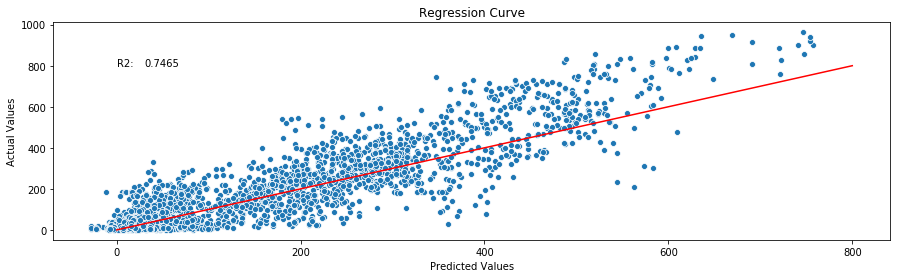

In [109]:
def weighted_plot():
    plt.subplots(figsize=(15, 4))
    ax = sns.scatterplot(y_pred_weighted, y_test)
    ax.set_title("Regression Curve")
    ax.set_ylabel("Actual Values")
    ax.set_xlabel("Predicted Values")
    fig.suptitle("Weighted Average", size=15)
    X_plot = np.linspace(0, 8, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 6, "R2:")
    ax2.text(0.5, 6, weighted_score)


weighted_plot()

### Stacking<a class="anchor" id="6.4.2"></a>

Now we will proceed to stacking. Stacking is basically taking the predictions of previous models and using them as new features (`X`) to train a new model. Usually there is a substantial increse in the scores after stacking, since different models are better predicting different aspects of the data, therefore with this approach we can take advantage of those different capabilities combined.

First we create a function that selects which models to stack, given a number by the user.

In [106]:
def models_to_stack(n_models):
    """
    models_to_stack(n_models)

    This function takes as an argument the desired number of models to be
    used for stacking. The function takes the 'n_models' number of models
    from the the best performing ones, starting with the best and adding
    them sectentially. Returns the models and their parameters to be used
    later on.
    """
    stacking_models = []
    if n_models == 1:
        print("Please choose more than one model...")
    elif n_models > 1:
        for n in range(n_models):
            stacking_models.append(eval(top_models.model[n]))
    return stacking_models

Now we create a function/model with the stacking embedded. This function works as a model with cross validation included.

In [114]:
def model_stacking(n_models, estimator, cv=3):
    """
    model_stacking(n_models, estimator, cv=3)

    This function takes as arguments the number of models 'n_models', the estimator
    or model to be used and the number of folds for cross validation. The function
    performs the stacking automatically given the parameters specified and returns
    the cross-validated score for the stacking predictions.
    """
    S_train, S_test = stacking(
        models_to_stack(n_models), X_train, y_train, X_test, metric=accuracy_score
    )
    estimator.fit(S_train, y_train)
    y_pred_stack = estimator.predict(S_test)
    stack_score = round(r2_score(y_test, y_pred_stack), 4)
    return stack_score

After we fit the stacked model we can proceed to print the scores and plot the accuracy curve and learning curve.

In [117]:
stack_score = model_stacking(n_models=5, estimator=gbr, cv=3)
print("Stacked R2: {}".format(stack_score))

Stacked R2: 0.9103


In [116]:
# models = models_to_stack(3)

# S_train, S_test = stacking(models,
#                            X_train, y_train, X_test,
#                            regression=False,
#                            mode='oof_pred_bag',
#                            needs_proba=False,
#                            save_dir=None,
#                            metric=accuracy_score,
#                            n_folds=3,
#                            stratified=True,
#                            shuffle=True,
#                            random_state=0)

# model = rf

# stack = model.fit(S_train, y_train)
# y_pred_stack = model.predict(S_test)
# stack_score = round(r2_score(y_test, y_pred_stack),4)

# print('Stacked R2: {}'.format(stack_score))

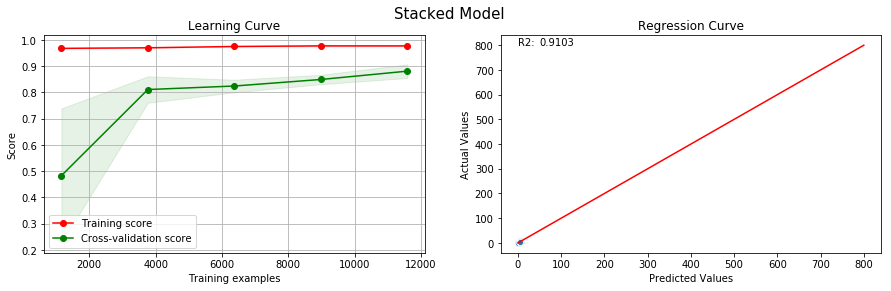

In [118]:
# Uncomment the cell above and run in order to save the variables used for this plot
# I commented it because I embedded the code in a function for easier use.


def stack_plot():
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    plot_learning_curve(stack, title="Learning Curve", X=X, y=y, ax=ax1)
    sns.scatterplot(y_pred_stack, y_test, ax=ax2)
    ax2.set_title("Regression Curve")
    ax2.set_ylabel("Actual Values")
    ax2.set_xlabel("Predicted Values")
    fig.suptitle("Stacked Model", size=15)
    X_plot = np.linspace(0, 800, 2)
    Y_plot = X_plot
    ax2.plot(X_plot, Y_plot, color="r")
    ax2.text(0, 800, "R2:")
    ax2.text(50, 800, stack_score)


stack_plot()

In [119]:
def result_plots(model):
    """
    result plots(model)

    This function is used to create a dropdown list using widgets.
    It takes as argument the model to be plotted and returns the plot
    for the learning curve and regression curve.
    """
    if model == "Select model...":
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    elif model == "Linear Regression":
        lr_plot()
    elif model == "Lasso Regression":
        lasso_plot()
    elif model == "Ridge Regression":
        ridge_plot()
    elif model == "ElasticNet":
        net_plot()
    elif model == "Linear SVM":
        lsvm_plot()
    elif model == "Non-linear SVM":
        nlsvm_plot()
    elif model == "Random Forest Regressor":
        rf_plot()
    elif model == "Gradient Boosting Regressor":
        gbr_plot()
    elif model == "XGBoost":
        xgbr_plot()
    elif model == "Weighted Average":
        weighted_plot()
    elif model == "Stacked Model":
        stack_plot()


options = [
    "Select model...",
    "Linear Regression",
    "Lasso Regression",
    "Ridge Regression",
    "ElasticNet",
    "Linear SVM",
    "Non-linear SVM",
    "Random Forest Regressor",
    "Gradient Boosting Regressor",
    "XGBoost",
    "Weighted Average",
    "Stacked Model",
]

---

# Conclusions<a class="anchor" id="7"></a>

After all the analysis we can say that we can condidently predict the number of bikes rented on a given day with an cross-validated accuracy of more than 91%.

In this particular case we argue that cross validation is not as necesary since we are dealing with time series data, therefore picking random rows to divide into `train` and  `test` is not the most accurate way to evaluate our models. Nevertheless even with cross validation the scores we got are equally good.

As we can see in the plot below the variables with most predicting power in the top performing model are `hour`, `humidity`, `temp` and our variable `atemp_comp`.

Curiously enough the first two appeared to be the least correlated to the target variable in the exploratory analysis. Contrary to our belief, the variables we created do not have as much predictive power as we thought.

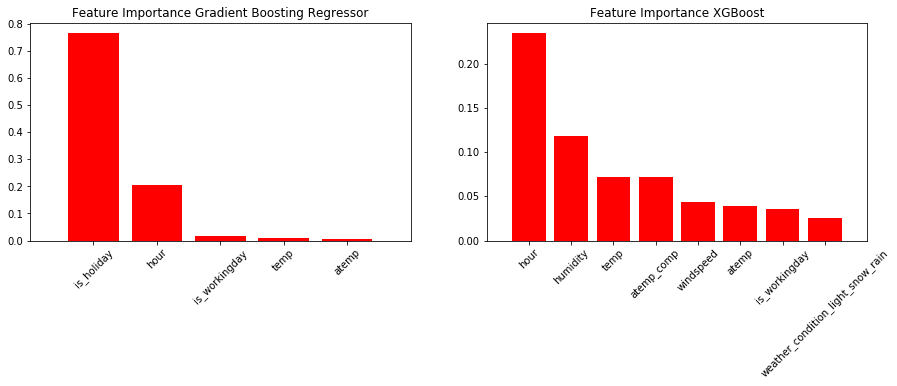

In [120]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
plot_feature_importances(
    gbr,
    feature_names=X.columns,
    x_tick_rotation=45,
    max_num_features=8,
    title="Feature Importance Gradient Boosting Regressor",
    ax=ax1,
)
plot_feature_importances(
    xgbr,
    feature_names=X.columns,
    x_tick_rotation=45,
    max_num_features=8,
    title="Feature Importance XGBoost",
    ax=ax2,
)

As a summary below we can find an interactive widget where we can select in a drop-down menu all the models we used and check their scores, learning curves and regression curves.

In [121]:
interact(result_plots, model=options)

interactive(children=(Dropdown(description='model', options=('Select model...', 'Linear Regression', 'Lasso Re…

<function __main__.result_plots(model)>

What we could do better:
- With more time and computational power, maybe we could have tuned the hyperparameters even more. As of now we can not be sure these are the best models possible.
- We could create pipelines to automate the whole process, from data ingestion to modeling and predicting.
- We could do some more research to include even more external data sources and see if they improve the models. usually the more domain knowledge we have, the better the feature engineering and modeling.
- We could also find a way to combine the time series analysis with the machine learning models to increase the scope of our predictions, it would be interesting to know how this two sciences interact together.